In [2]:
! pip install SimpleITK h5py

  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl.metadata (2.7 kB)
   ---------------------------------------- 0.0/18.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/18.8 MB 5.6 MB/s eta 0:00:04
   ------ --------------------------------- 2.9/18.8 MB 16.8 MB/s eta 0:00:01
   ---------- ----------------------------- 4.7/18.8 MB 10.2 MB/s eta 0:00:02
   ------------- -------------------------- 6.6/18.8 MB 9.4 MB/s eta 0:00:02
   ----------------- ---------------------- 8.1/18.8 MB 9.2 MB/s eta 0:00:02
   -------------------- ------------------- 9.4/18.8 MB 8.6 MB/s eta 0:00:02
   ----------------------- ---------------- 11.0/18.8 MB 8.3 MB/s eta 0:00:01
   -------------------------- ------------- 12.3/18.8 MB 8.1 MB/s eta 0:00:01
   ----------------------------- ---------- 13.9/18.8 MB 7.9 MB/s eta 0:00:01
   -------------------------------- ------- 15.2/18.8 MB 7.8 MB/s eta 0:00:01
   ----------------------------------- ---- 16.8/18.8 MB 7.8 MB/s eta 0:00:01
   --

In [ ]:
import os 
import numpy as np 
import pandas as pd 
import SimpleITK as sitk
import h5py
from tqdm import tqdm 
import cv2 

def load_ac_csv(csv_path):
    df = pd.read_csv(csv_path)
    if "uuid" not in df.columns:
        raise ValueError(f"Expected 'uuid' column in {csv_path}, found {list(df.columns)}")
    return df.set_index("uuid")


def get_reference_ac(ac_df, uuid, strategy="first"):
    """
    Get AC (abdominal circumference) ground truth for a case.
    strategy: "first" | "mean" | "max"
    """
    try:
        ac_row = ac_df.loc[uuid]
        ac_values = ac_row.filter(like="sweep_").dropna().values.astype(float)
        if len(ac_values) == 0:
            return None
        if strategy == "first":
            return float(ac_values[0])
        elif strategy == "mean":
            return float(ac_values.mean())
        elif strategy == "max":
            return float(ac_values.max())
        else:
            raise ValueError(f"Unknown strategy {strategy}")
    except KeyError:
        print(f"⚠️ Missing AC entry for {uuid}")
        return None


def get_suitability_score(mask_np):
    """
    Soft labels:
      1.0 = contains label 1 (optimal)
      0.6 = contains label 2 (suboptimal)
      0.0 = empty
    If both 1 and 2 exist in same frame → take the higher (1.0).
    """
    scores = []
    for frame in mask_np:
        has_1 = (frame == 1).any()
        has_2 = (frame == 2).any()
        if has_1:
            scores.append(1.0)
        elif has_2:
            scores.append(0.6)
        else:
            scores.append(0.0)
    return np.array(scores, dtype=np.float32)



def convert_acouslic_to_hdf5_classifier_small(
    image_dir,
    mask_dir,
    csv_path,
    output_dir,
    limit=None,
    pixel_spacing=0.28,
    target_size=(281, 372),  # H, W
):
    os.makedirs(output_dir, exist_ok=True)
    ac_df = load_ac_csv(csv_path)

    mha_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".mha")])
    converted = 0

    for f in tqdm(mha_files, desc="Converting ACOUSLIC to small HDF5"):
        if limit is not None and converted >= limit:
            break

        case_id = f.replace(".mha", "")
        uuid = case_id
        image_path = os.path.join(image_dir, f)
        mask_path = os.path.join(mask_dir, f)
        output_path = os.path.join(output_dir, f"{case_id}.h5")

        if os.path.exists(output_path):
            print(f"ℹ️ Skipping {case_id}: already exists.")
            continue

        try:
            # Load volumes
            img = sitk.ReadImage(image_path)
            mask = sitk.ReadImage(mask_path)
            img_np = sitk.GetArrayFromImage(img).astype(np.float32)  # [T,H,W]
            mask_np = sitk.GetArrayFromImage(mask).astype(np.uint8)

            if img_np.shape != mask_np.shape:
                print(f"⚠️ Shape mismatch {case_id}: {img_np.shape} vs {mask_np.shape}")
                continue

            T,H,W = img_np.shape
            new_H, new_W = target_size

            # Resize with INTER_AREA
            img_ds = np.array([
                cv2.resize(frame, (new_W,new_H), interpolation=cv2.INTER_AREA)
                for frame in img_np
            ])

            # Normalize to [0,1], store as float16
            lo, hi = np.percentile(img_ds, [1, 99])
            img_ds = np.clip((img_ds - lo) / (hi - lo + 1e-6), 0, 1)
            img_ds = img_ds.astype(np.float16)

            img_ds = img_ds[..., np.newaxis]  # [T,H,W,1]

            # Labels
            cls_label = get_suitability_score(mask_np)
            ac_mm = get_reference_ac(ac_df, uuid)
            if ac_mm is None:
                print(f"⚠️ Missing AC for {uuid}, skipping.")
                continue

            # Save with gzip level 4 (balanced compression)
            with h5py.File(output_path, "w") as hf:
                hf.create_dataset("image", data=img_ds, 
                                  compression="gzip", compression_opts=4,
                                  chunks=(1,new_H,new_W,1))
                hf.create_dataset("cls_label", data=cls_label, 
                                  compression="gzip", compression_opts=4)
                hf.attrs["uuid"] = uuid
                hf.attrs["pixel_spacing"] = float(pixel_spacing)
                hf.attrs["ac_reference"] = float(ac_mm)

            size_mb = os.path.getsize(output_path)/1024/1024
            print(f"✅ Saved {case_id} | AC={ac_mm:.2f} | Frames={img_ds.shape[0]} | Size={size_mb:.2f} MB")
            converted += 1

        except Exception as e:
            print(f"❌ Error {case_id}: {e}")
            traceback.print_exc()


In [6]:
convert_acouslic_to_hdf5_classifier_small(
    image_dir="D:/dataset/acouslic-ai-train-set/images/stacked_fetal_ultrasound",
    mask_dir="D:/dataset/acouslic-ai-train-set/masks/stacked_fetal_abdomen",
    csv_path="D:/dataset/acouslic-ai-train-set/circumferences/fetal_abdominal_circumferences_per_sweep.csv",
    output_dir="D:/dataset/converted_classifier_h5_nomask",
    limit=10
)

Converting ACOUSLIC to small HDF5:   0%|          | 0/300 [00:00<?, ?it/s]

Converting ACOUSLIC to small HDF5:   0%|          | 1/300 [00:04<20:51,  4.19s/it]

✅ Saved 0199616b-bdeb-4119-97a3-a5a3571bd641 | AC=312.27 | Frames=840 | Size=57.17 MB


Converting ACOUSLIC to small HDF5:   1%|          | 2/300 [00:08<20:15,  4.08s/it]

✅ Saved 02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1 | AC=257.17 | Frames=840 | Size=54.71 MB


Converting ACOUSLIC to small HDF5:   1%|          | 3/300 [00:13<21:58,  4.44s/it]

✅ Saved 02ee26a5-a665-4531-bec1-8bac83345a94 | AC=216.96 | Frames=840 | Size=51.13 MB


Converting ACOUSLIC to small HDF5:   1%|▏         | 4/300 [00:16<20:29,  4.15s/it]

✅ Saved 032b9024-3685-4a81-a62e-813d2da3d387 | AC=221.23 | Frames=840 | Size=54.20 MB


Converting ACOUSLIC to small HDF5:   2%|▏         | 5/300 [00:20<19:49,  4.03s/it]

✅ Saved 0428da3d-fef4-4c9b-96f2-5ffedaee82d0 | AC=260.38 | Frames=840 | Size=58.58 MB


Converting ACOUSLIC to small HDF5:   2%|▏         | 6/300 [00:24<19:35,  4.00s/it]

✅ Saved 046ed03e-4b35-4519-bb5f-cd4b0474a060 | AC=302.21 | Frames=840 | Size=51.66 MB


Converting ACOUSLIC to small HDF5:   2%|▏         | 7/300 [00:28<19:56,  4.08s/it]

✅ Saved 04a04f2e-840b-47f8-a907-abe7aeab3f41 | AC=271.63 | Frames=840 | Size=58.81 MB


Converting ACOUSLIC to small HDF5:   3%|▎         | 8/300 [00:32<19:48,  4.07s/it]

✅ Saved 04ef1176-7d54-4942-899d-f0fa69ad34bb | AC=189.67 | Frames=840 | Size=54.50 MB


Converting ACOUSLIC to small HDF5:   3%|▎         | 9/300 [00:37<20:00,  4.12s/it]

✅ Saved 056764b4-7c0c-4452-832d-3d1cbb5a0464 | AC=248.34 | Frames=840 | Size=62.04 MB


Converting ACOUSLIC to small HDF5:   3%|▎         | 10/300 [00:41<19:52,  4.11s/it]

✅ Saved 05f72776-bf41-40ea-bdea-a7bcfa1eb9ba | AC=286.23 | Frames=840 | Size=59.95 MB


In [7]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import h5py
from tqdm import tqdm
import cv2
import traceback

# -------------------------------------------
# Utilities
# -------------------------------------------
def load_ac_csv(csv_path):
    df = pd.read_csv(csv_path)
    if "uuid" not in df.columns:
        raise ValueError(f"Expected 'uuid' column in {csv_path}, found {list(df.columns)}")
    return df.set_index("uuid")

def get_reference_ac(ac_df, uuid, strategy="first"):
    try:
        ac_row = ac_df.loc[uuid]
        ac_values = ac_row.filter(like="sweep_").dropna().values.astype(float)
        if len(ac_values) == 0:
            return None
        if strategy == "first":
            return float(ac_values[0])
        elif strategy == "mean":
            return float(ac_values.mean())
        elif strategy == "max":
            return float(ac_values.max())
        else:
            raise ValueError(f"Unknown strategy {strategy}")
    except KeyError:
        print(f"⚠️ Missing AC entry for {uuid}")
        return None

def get_suitability_score(mask_np):
    """Soft labels for classification"""
    scores = []
    for frame in mask_np:
        has_1 = (frame == 1).any()
        has_2 = (frame == 2).any()
        if has_1:
            scores.append(1.0)
        elif has_2:
            scores.append(0.6)
        else:
            scores.append(0.0)
    return np.array(scores, dtype=np.float32)

# -------------------------------------------
# Converter (classification only)
# -------------------------------------------
def convert_acouslic_to_hdf5_classifier_uint8(
    image_dir,
    mask_dir,
    csv_path,
    output_dir,
    limit=None,
    pixel_spacing=0.28,
    target_size=(281, 372)  # H, W
):
    os.makedirs(output_dir, exist_ok=True)
    ac_df = load_ac_csv(csv_path)

    mha_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".mha")])
    converted = 0

    for f in tqdm(mha_files, desc="Converting ACOUSLIC to HDF5 (uint8, gzip-9)"):
        if limit is not None and converted >= limit:
            break

        case_id = f.replace(".mha", "")
        uuid = case_id
        image_path = os.path.join(image_dir, f)
        mask_path = os.path.join(mask_dir, f)
        output_path = os.path.join(output_dir, f"{case_id}.h5")

        if os.path.exists(output_path):
            print(f"ℹ️ Skipping {case_id}: already exists.")
            continue

        try:
            # Load volumes
            img = sitk.ReadImage(image_path)
            mask = sitk.ReadImage(mask_path)
            img_np = sitk.GetArrayFromImage(img).astype(np.float32)  # [T,H,W]
            mask_np = sitk.GetArrayFromImage(mask).astype(np.uint8)

            if img_np.shape != mask_np.shape:
                print(f"⚠️ Shape mismatch {case_id}: {img_np.shape} vs {mask_np.shape}")
                continue

            T, H, W = img_np.shape
            new_H, new_W = target_size

            # Resize (INTER_AREA for downsampling)
            img_ds = np.array([
                cv2.resize(frame, (new_W, new_H), interpolation=cv2.INTER_AREA)
                for frame in img_np
            ])

            # Normalize to [0,255], store as uint8
            img_ds -= img_ds.min()
            img_ds /= (img_ds.max() + 1e-8)
            img_ds = (img_ds * 255).astype(np.uint8)

            # Add channel dimension
            img_ds = img_ds[..., np.newaxis]  # [T,H,W,1]

            # Labels
            cls_label = get_suitability_score(mask_np)
            ac_mm = get_reference_ac(ac_df, uuid)
            if ac_mm is None:
                print(f"⚠️ Missing AC for {uuid}, skipping.")
                continue

            # Save with maximum compression
            with h5py.File(output_path, "w") as hf:
                hf.create_dataset(
                    "image", data=img_ds,
                    compression="gzip", compression_opts=9,
                    chunks=(1, new_H, new_W, 1)
                )
                hf.create_dataset(
                    "cls_label", data=cls_label,
                    compression="gzip", compression_opts=9
                )
                hf.attrs["uuid"] = uuid
                hf.attrs["pixel_spacing"] = float(pixel_spacing)
                hf.attrs["ac_reference"] = float(ac_mm)

            size_mb = os.path.getsize(output_path) / 1024 / 1024
            print(f"✅ Saved {case_id} | AC={ac_mm:.2f} | Frames={img_ds.shape[0]} | Size={size_mb:.2f} MB")
            converted += 1

        except Exception as e:
            print(f"❌ Error {case_id}: {e}")
            traceback.print_exc()


In [8]:
convert_acouslic_to_hdf5_classifier_uint8(
    image_dir="D:/dataset/acouslic-ai-train-set/images/stacked_fetal_ultrasound",
    mask_dir="D:/dataset/acouslic-ai-train-set/masks/stacked_fetal_abdomen",
    csv_path="D:/dataset/acouslic-ai-train-set/circumferences/fetal_abdominal_circumferences_per_sweep.csv",
    output_dir="D:/dataset/converted_classifier_h5_uint8",
    limit=10
)

Converting ACOUSLIC to HDF5 (uint8, gzip-9):   0%|          | 1/300 [00:04<20:19,  4.08s/it]

✅ Saved 0199616b-bdeb-4119-97a3-a5a3571bd641 | AC=312.27 | Frames=840 | Size=33.87 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   1%|          | 2/300 [00:08<21:52,  4.40s/it]

✅ Saved 02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1 | AC=257.17 | Frames=840 | Size=32.01 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   1%|          | 3/300 [00:13<22:48,  4.61s/it]

✅ Saved 02ee26a5-a665-4531-bec1-8bac83345a94 | AC=216.96 | Frames=840 | Size=31.31 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   1%|▏         | 4/300 [00:18<22:44,  4.61s/it]

✅ Saved 032b9024-3685-4a81-a62e-813d2da3d387 | AC=221.23 | Frames=840 | Size=31.52 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   2%|▏         | 5/300 [00:23<23:53,  4.86s/it]

✅ Saved 0428da3d-fef4-4c9b-96f2-5ffedaee82d0 | AC=260.38 | Frames=840 | Size=34.44 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   2%|▏         | 6/300 [00:28<24:43,  5.05s/it]

✅ Saved 046ed03e-4b35-4519-bb5f-cd4b0474a060 | AC=302.21 | Frames=840 | Size=29.99 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   2%|▏         | 7/300 [00:33<24:27,  5.01s/it]

✅ Saved 04a04f2e-840b-47f8-a907-abe7aeab3f41 | AC=271.63 | Frames=840 | Size=33.61 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   3%|▎         | 8/300 [00:39<25:04,  5.15s/it]

✅ Saved 04ef1176-7d54-4942-899d-f0fa69ad34bb | AC=189.67 | Frames=840 | Size=32.13 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   3%|▎         | 9/300 [00:43<23:52,  4.92s/it]

✅ Saved 056764b4-7c0c-4452-832d-3d1cbb5a0464 | AC=248.34 | Frames=840 | Size=37.08 MB


Converting ACOUSLIC to HDF5 (uint8, gzip-9):   3%|▎         | 10/300 [00:48<23:20,  4.83s/it]

✅ Saved 05f72776-bf41-40ea-bdea-a7bcfa1eb9ba | AC=286.23 | Frames=840 | Size=34.79 MB


File: 05f72776-bf41-40ea-bdea-a7bcfa1eb9ba.h5
shape: (840, 281, 372, 1) | dtype: uint8 | min/max: 0 255
labels shape: (840,) | unique label values: [0.  0.6]
attrs: {'ac_reference': np.float64(286.23024762117785), 'pixel_spacing': np.float64(0.28), 'uuid': '05f72776-bf41-40ea-bdea-a7bcfa1eb9ba'}


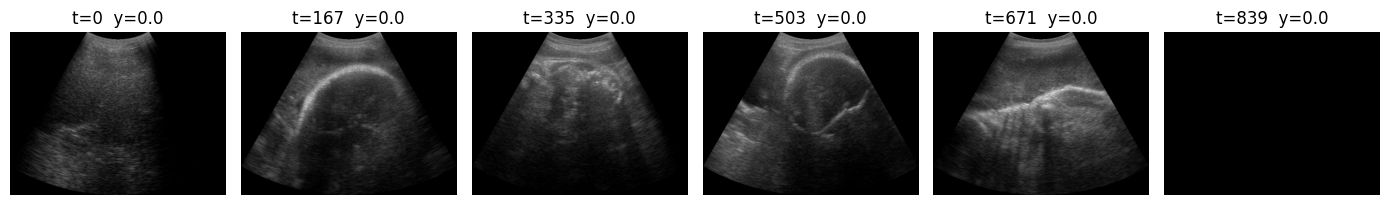

In [10]:
import h5py, numpy as np, matplotlib.pyplot as plt, random, os

h5_dir = r"D:/dataset/converted_classifier_h5_uint8"
sample = random.choice([f for f in os.listdir(h5_dir) if f.endswith(".h5")])
path = os.path.join(h5_dir, sample)

with h5py.File(path, "r") as hf:
    imgs = hf["image"][:]        # [T,H,W,1], uint8
    cls  = hf["cls_label"][:]    # [T], float32
    meta = dict(hf.attrs)

print("File:", sample)
print("shape:", imgs.shape, "| dtype:", imgs.dtype, "| min/max:", imgs.min(), imgs.max())
print("labels shape:", cls.shape, "| unique label values:", np.unique(cls))
print("attrs:", meta)

# show a few frames + their labels
T = imgs.shape[0]
idxs = np.linspace(0, T-1, num=min(6, T), dtype=int)
fig, axes = plt.subplots(1, len(idxs), figsize=(14,3))
for ax, i in zip(axes, idxs):
    ax.imshow(imgs[i,...,0], cmap="gray", vmin=0, vmax=255)
    ax.set_title(f"t={i}  y={cls[i]:.1f}")
    ax.axis("off")
plt.tight_layout()
plt.show()


unique (H,W): {(281, 372)}
image dtypes: {dtype('uint8')}
pixel value range across files: min= 0 max= 255
label counts: {0.0: 8182, 0.6000000238418579: 130, 1.0: 88}


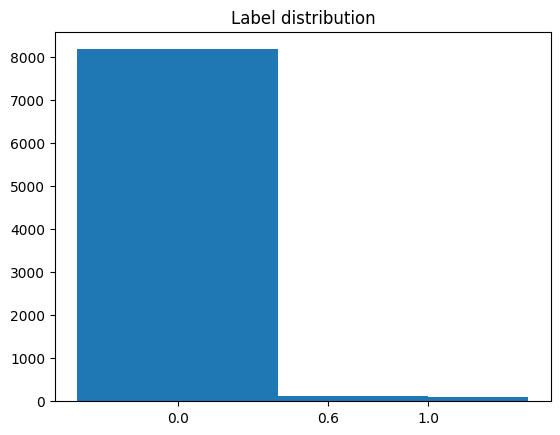

In [11]:
import os, h5py, numpy as np, collections, matplotlib.pyplot as plt

h5_dir = r"D:/dataset/converted_classifier_h5_uint8"
files = [os.path.join(h5_dir,f) for f in os.listdir(h5_dir) if f.endswith(".h5")]

shapes = []
dtypes = set()
vals_min, vals_max = [], []
label_hist = collections.Counter()

for p in files[:100]:  # sample first 100, or all if small
    with h5py.File(p, "r") as hf:
        imgs = hf["image"]
        cls  = hf["cls_label"][:]
        shapes.append(imgs.shape[1:3])
        dtypes.add(imgs.dtype)
        vals_min.append(imgs[:].min()); vals_max.append(imgs[:].max())
        for v in cls: label_hist[float(v)] += 1

print("unique (H,W):", set(map(tuple, shapes)))
print("image dtypes:", dtypes)
print("pixel value range across files: min=", np.min(vals_min), "max=", np.max(vals_max))
print("label counts:", dict(label_hist))

# label distribution bar
plt.bar(list(label_hist.keys()), list(label_hist.values()))
plt.xticks([0.0,0.6,1.0]); plt.title("Label distribution"); plt.show()
